In [134]:
import numpy as np
import pandas as pd
import os

from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
import shap
import umap.umap_ as umap

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import json


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders import BinaryEncoder
from sklearn.impute import SimpleImputer

In [124]:

file_path = os.path.join("data","processed_data.csv")

df = pd.read_csv(file_path)  

X = df.drop(columns=['Class', 'WsRF', 'Latency', 'Best Practices', 'Response Time']) 
Y = df['Class']

# Define baseline

In [125]:

baseline_model = LogisticRegression(random_state=42)

scalers=[StandardScaler(), MinMaxScaler()]

for scaler in scalers:
    
    print(f'=== Scaller: {scaler}====')
    X_scalled = scaler.fit_transform(X)
    
    X_rest, X_test, Y_rest, Y_test = train_test_split(X_scalled,Y, test_size=0.15, random_state=42)
    X_train, X_val, Y_train, Y_val = train_test_split(X_rest,Y_rest, test_size=0.2, random_state=42)

    baseline_model.fit(X_train, Y_train)

    # 4. Predict on test set
    y_pred = baseline_model.predict(X_val)

    # 5. Evaluate performance
    print("Baseline Accuracy:", accuracy_score(Y_val, y_pred))
    print("\nClassification Report:\n", classification_report(Y_val, y_pred))


=== Scaller: StandardScaler()====
Baseline Accuracy: 0.9354838709677419

Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.89      0.94         9
           2       0.94      0.89      0.92        19
           3       0.83      1.00      0.91        15
           4       1.00      0.95      0.97        19

    accuracy                           0.94        62
   macro avg       0.94      0.93      0.94        62
weighted avg       0.94      0.94      0.94        62

=== Scaller: MinMaxScaler()====
Baseline Accuracy: 0.9193548387096774

Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.89      0.94         9
           2       0.89      0.89      0.89        19
           3       0.83      1.00      0.91        15
           4       1.00      0.89      0.94        19

    accuracy                           0.92        62
   macro avg       0.93      0.92      0.92    

StandardScaler gives better accuracy

- feature importance in baseline model

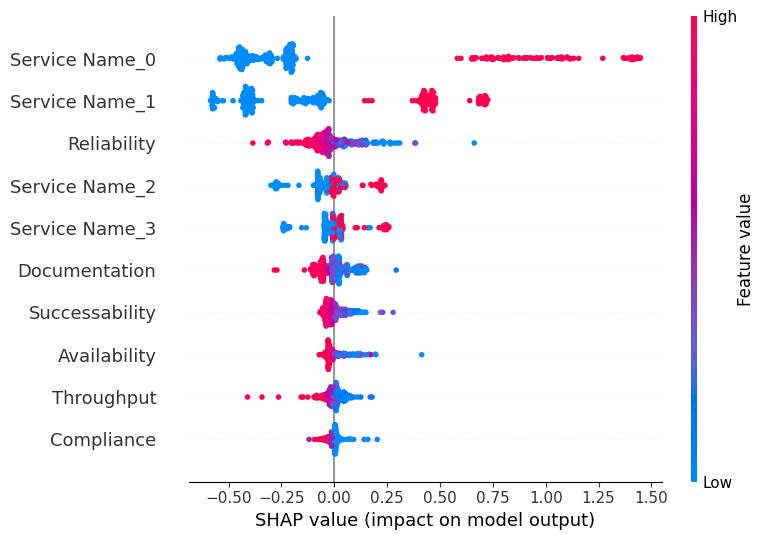

In [117]:
scalers=StandardScaler()
X_scalled = scaler.fit_transform(X)
X_scalled=pd.DataFrame(X_scalled, columns = X.columns)

X_rest, X_test, Y_rest, Y_test = train_test_split(X_scalled,Y, test_size=0.15, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_rest,Y_rest, test_size=0.2, random_state=42)

baseline_model.fit(X_rest,Y_rest)
explainer = shap.Explainer(baseline_model.predict, X_rest)  
shap_values = explainer(X_rest)

shap.summary_plot(shap_values, X_rest)

Removing Response Time, Best Pratices and Latency can reduce overfitting risk; Improve model interpretability; Speed up training and inference.

[0.00647249 0.01100324 0.00550162 0.0184466  0.00485437 0.00873786
 0.14854369 0.32006472 0.1038835  0.05533981]


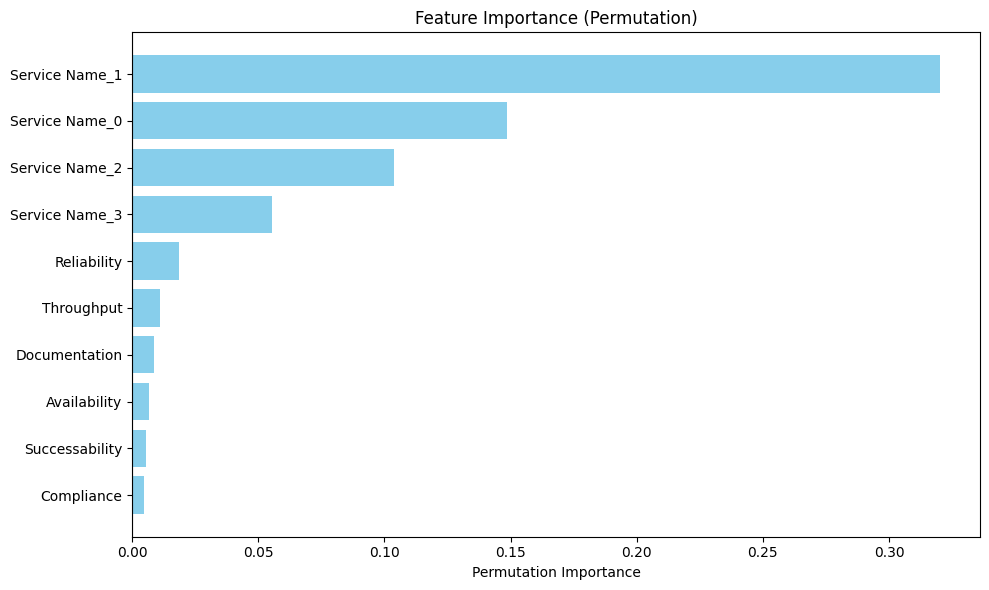

In [ ]:
result = permutation_importance(baseline_model, X_rest, Y_rest, n_repeats=10, random_state=42)
print(result.importances_mean)


# Feature names and importance values
importances = result.importances_mean
features = X_rest.columns

# Create DataFrame for sorting
df = pd.DataFrame({'Feature': features, 'Importance': importances})
df_sorted = df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(df_sorted['Feature'], df_sorted['Importance'], color='skyblue')
plt.xlabel('Permutation Importance')
plt.title('Feature Importance (Permutation)')
plt.gca().invert_yaxis()  # Highest importance at top
plt.axvline(0, color='gray', linewidth=0.8)
plt.tight_layout()
plt.show()

High permutation importance might come from interactions or leakage rather than true explanatory power.
Keeping them could lead to overfitting, especially if they represent identifiers rather than meaningful attributes.

- With dimensionality reduction

In [119]:
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scalled)

X_rest, X_test, Y_rest, Y_test = train_test_split(X_umap,Y, test_size=0.15, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_rest,Y_rest, test_size=0.2, random_state=42)

baseline_model.fit(X_train, Y_train)

# 4. Predict on test set
y_pred = baseline_model.predict(X_val)

# 5. Evaluate performance
print("Baseline Accuracy:", accuracy_score(Y_val, y_pred))
print("\nClassification Report:\n", classification_report(Y_val, y_pred))

c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Baseline Accuracy: 0.5967741935483871

Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.78      0.88         9
           2       0.53      0.53      0.53        19
           3       0.53      0.60      0.56        15
           4       0.58      0.58      0.58        19

    accuracy                           0.60        62
   macro avg       0.66      0.62      0.64        62
weighted avg       0.61      0.60      0.60        62



# RandomizedSearchCV

In [109]:
models = {
    'lr': LogisticRegression(max_iter=1000, random_state=42),
    'dt': DecisionTreeClassifier(),
    'rf': RandomForestClassifier(max_depth=2, random_state=42),
    'nb': GaussianNB(),
    'svm': svm.SVC(probability=True),
    'knc': KNeighborsClassifier(n_neighbors=3),
    'xgb': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, probability=True)
}

param_grids = {
    'lr': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear']
    },
    'dt': {
        'max_depth': [None, 3, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'rf': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'svm': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'knc': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    },
    'xgb': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
}

k_folds = KFold(n_splits=5)
model_scores = {}


In [ ]:

k_folds = KFold(n_splits = 5)

model_scores={}

for name, model in models.items():
    if name in param_grids:
        
        if name =='xgb':
            Y_rest = Y_rest - 1
            
        search = RandomizedSearchCV(model, param_grids[name], cv=k_folds, scoring='accuracy', n_jobs=-1)
        search.fit(X_rest if name in ['lr', 'svm', 'knc'] else X_rest, Y_rest)
        best_score = search.best_score_
        best_model = search.best_estimator_
        print(f"{name}: Best Score={best_score:.4f}, Best Params={search.best_params_}")
    else:
        scores = cross_val_score(model, X_rest, Y_rest, cv=k_folds, scoring='accuracy')
        best_score = scores.mean()
        best_model = model.fit(X_rest, Y_rest)
        print(f"{name}: Score={best_score:.4f}")
    
    model_scores[name] = (best_score, best_model)

# Select best model
best_model_name = max(model_scores, key=lambda k: model_scores[k][0])

if best_model_name != 'xbg' : 
    Y_rest = Y_rest + 1

best_model = model_scores[best_model_name][1]
print(f"\nBest model: {best_model_name} with score {model_scores[best_model_name][0]:.4f}")



c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


lr: Best Score=0.6572, Best Params={'solver': 'liblinear', 'C': 10}
dt: Best Score=0.8997, Best Params={'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 5}
rf: Best Score=0.9126, Best Params={'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': None}
nb: Score=0.7314


KeyboardInterrupt: 

In [ ]:
best_model.fit(X_rest, Y_rest)

y_pred = best_model.predict(X_test)
y_score = best_model.predict_proba(X_test)

print('Best Model ', best_model_name)
print(f"Test Accuracy: {accuracy_score(Y_test, y_pred):.4f}")
print(classification_report(Y_test, y_pred))

Best Model  svm
Test Accuracy: 0.9091
              precision    recall  f1-score   support

           1       1.00      0.78      0.88         9
           2       0.83      0.94      0.88        16
           3       0.88      0.93      0.90        15
           4       1.00      0.93      0.97        15

    accuracy                           0.91        55
   macro avg       0.93      0.90      0.91        55
weighted avg       0.92      0.91      0.91        55



In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    classes = np.unique(y_true)  # [1, 2, 3, 4]

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
def plot_roc_curve(y_true, y_score):
    classes = np.unique(y_true)  # [1, 2, 3, 4]

    plt.figure(figsize=(6, 5))
    
    for idx, cls in enumerate(classes):
        
        fpr, tpr, _ = roc_curve(y_true == cls, y_score[:, idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {cls} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()


In [ ]:
def plot_precision_recall(y_true, y_score):

    classes = np.unique(y_true)  # [1, 2, 3, 4]
    
    plt.figure(figsize=(6, 5))

    for idx, cls in enumerate(classes):  # idx = 0..3, cls = 1..4
    
        precision, recall, _ = precision_recall_curve(y_true == cls, y_score[:, idx])
        plt.plot(recall, precision, label=f'Class {cls}')
    
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

In [ ]:
def plot_class_accuracy(y_true, y_pred):
    classes = np.unique(y_true)  # [1, 2, 3, 4]
    
    accuracies = []
    for cls in classes:
        cls_idx = (y_true == cls)
        acc = np.mean(y_pred[cls_idx] == cls)
        accuracies.append(acc)
    
    plt.figure(figsize=(6, 4))
    sns.barplot(x=classes, y=accuracies)
    plt.title('Class-wise Accuracy')
    plt.ylabel('Accuracy')


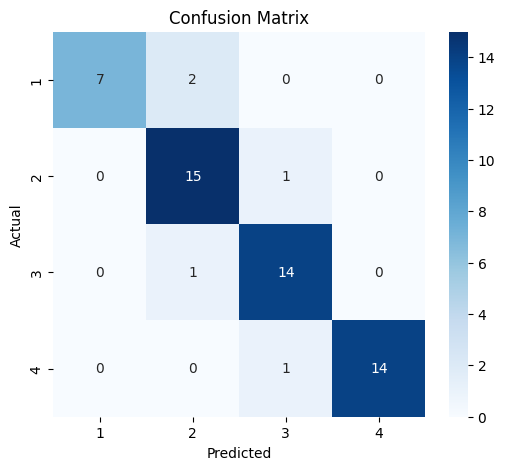

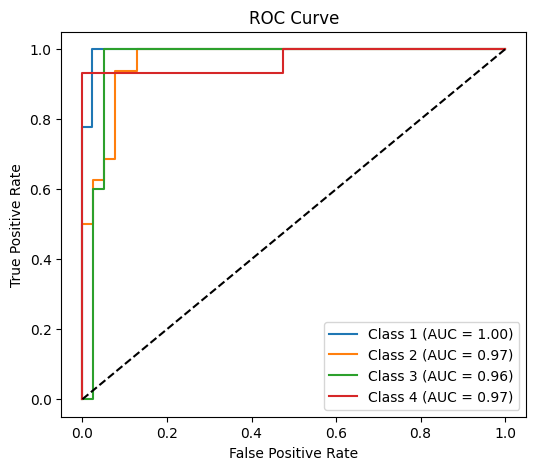

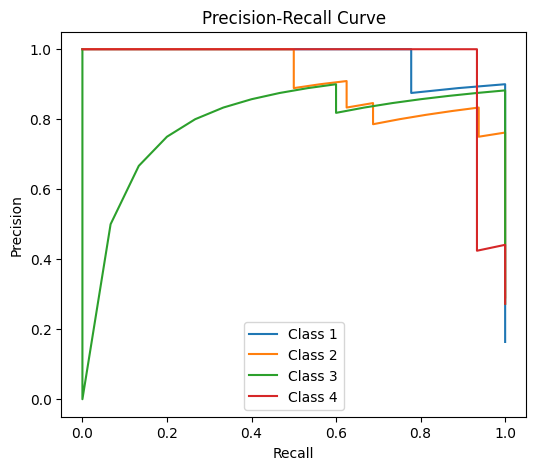

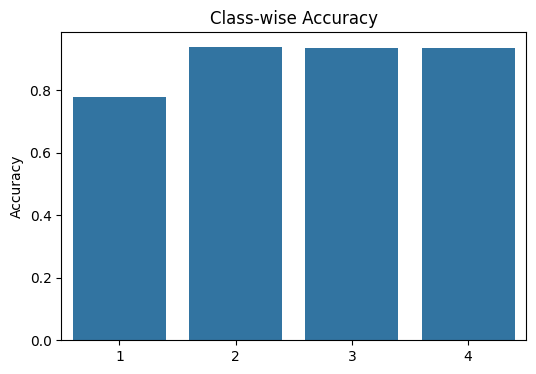

In [ ]:
plot_confusion_matrix(Y_test, y_pred)
plot_roc_curve(Y_test, y_score)
plot_precision_recall(Y_test, y_score)
plot_class_accuracy(Y_test, y_pred)

In [130]:
X.columns

Index(['Availability', 'Throughput', 'Successability', 'Reliability',
       'Compliance', 'Documentation', 'Service Name_0', 'Service Name_1',
       'Service Name_2', 'Service Name_3'],
      dtype='object')

In [150]:
pd.DataFrame(X_train, columns=X.columns)

,Availability,Throughput,Successability,Reliability,Compliance,Documentation,Service Name_0,Service Name_1,Service Name_2,Service Name_3
0,1.000000,0.625954,0.793478,0.909586,0.333333,0.937500,0.0,0.0,0.0,0.0
1,0.776316,0.255725,0.467391,0.799564,0.333333,0.010417,1.0,0.0,0.0,0.0
2,0.776316,0.595420,0.467391,0.766885,0.666667,0.104167,0.0,1.0,1.0,0.0
3,1.000000,0.022901,0.771739,0.369281,0.333333,0.406250,1.0,0.0,0.0,0.0
4,0.842105,0.110687,0.467391,0.436819,0.333333,0.052083,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
242,1.000000,0.049618,0.902174,0.153595,0.333333,0.989583,0.0,1.0,1.0,0.0
243,0.513158,0.316794,0.336957,0.481481,0.666667,0.083333,1.0,0.0,0.0,1.0
244,1.000000,0.194656,0.902174,0.818083,1.000000,0.104167,0.0,0.0,1.0,0.0
245,0.289474,0.152672,0.217391,0.330065,0.666667,0.093750,1.0,0.0,1.0,0.0


In [157]:
numeric_features = ['Availability', 'Throughput', 'Successability', 
                    'Reliability', 'Compliance', 'Documentation']
categorical_features = ['Service Name']

# Convert to DataFrame with column names
X_train = pd.DataFrame(X_train, columns= X.columns)
X_test = pd.DataFrame(X_test, columns= X.columns)

# Winsorization function
def winsorize(X):
    df = pd.DataFrame(X, columns=numeric_features)
    for col in numeric_features:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = np.clip(df[col], lower, upper)
    return df.values

winsorizer = FunctionTransformer(winsorize, validate=False)

numeric_transformer = Pipeline(steps=[
    ("winsorizer", winsorizer),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", BinaryEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

In [159]:
numeric_features = ['Availability', 'Throughput', 'Successability', 
                    'Reliability', 'Compliance', 'Documentation']

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

def winsorize(X):
    df = pd.DataFrame(X, columns=numeric_features)
    for col in numeric_features:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = np.clip(df[col], lower, upper)
    return df.values

winsorizer = FunctionTransformer(winsorize, validate=False)

numeric_transformer = Pipeline(steps=[
    ("winsorizer", winsorizer),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", BinaryEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, [0, 1, 2, 3, 4, 5]),  # numeric columns
    ("cat", categorical_transformer, [6])  # categorical column
])


In [ ]:

pipeline = Pipeline(steps=[
    ("model", best_model)
])

# Fit the pipeline
pipeline.fit(X_rest, Y_rest)

# Predictions
y_pred = pipeline.predict(X_test)

# Metrics dictionary
metrics = {
    "accuracy": accuracy_score(Y_test, y_pred),
    "precision": precision_score(Y_test, y_pred, average="binary"),  # or "macro" for multi-class
    "recall": recall_score(Y_test, y_pred, average="binary"),
    "f1_score": f1_score(Y_test, y_pred, average="binary")
}


c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [ ]:

# Save the entire pipeline
joblib.dump(pipeline, "best_pipeline.pkl")

# JSON
import json
with open("metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

# CSV
import pandas as pd
pd.DataFrame([metrics]).to_csv("metrics.csv", index=False)
